In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle


In [2]:
from sklearn.metrics import confusion_matrix

### Naive Random Walk, judt push the images to the networks and see if they can learn to extract information fro m a random combination of images.
In this implimintation we have the Syclop run a random walk on the image, we will see if a basic CNN or RNN network can work with a changing path over the images. 
<br> For each image a new, random, path will be initialized.
<br> This does not work at all, the networks run poorly compared to the case when the same random path is used for all images. 
<br> 

In [3]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/labs/ahissarlab/orra/imagewalker/misc.py'>

In [4]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

fmnist = torchvision.datasets.FashionMNIST('/home/labs/ahissarlab/orra/datasets/fmnist', train = True, download = True)
images, labels = fmnist.data, fmnist.targets
# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc



In [5]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

<IPython.core.display.Javascript object>


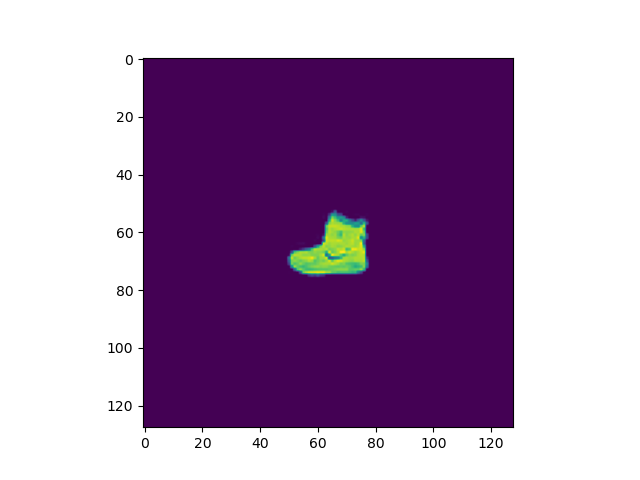

In [6]:
plt.figure()
plt.imshow(misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28])))

In [7]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [8]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [9]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [38, 37],
       [39, 35],
       [34, 32],
       [30, 32]])

In [10]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


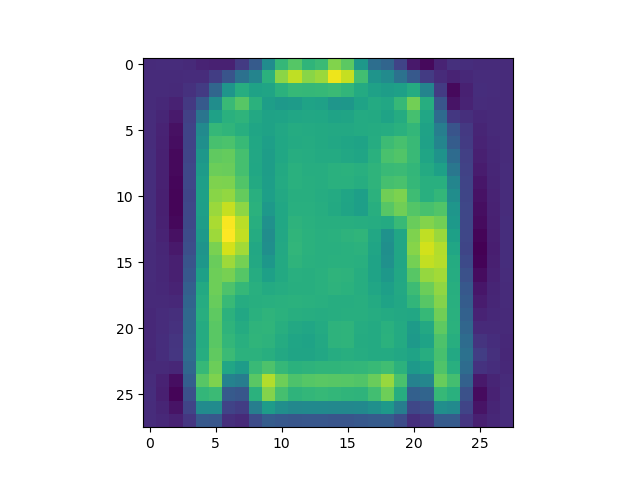

<IPython.core.display.Javascript object>


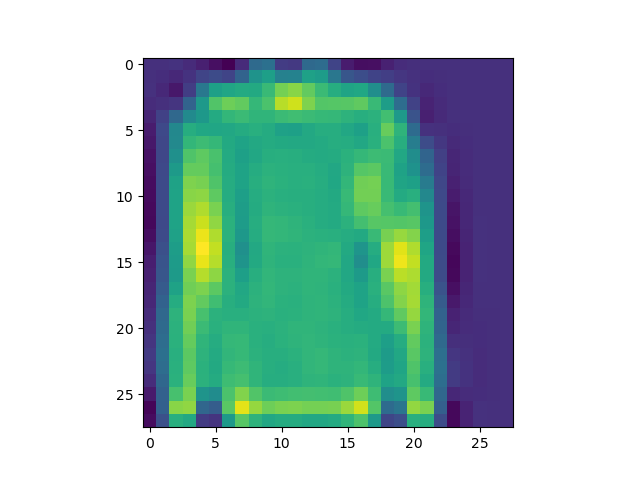

<IPython.core.display.Javascript object>


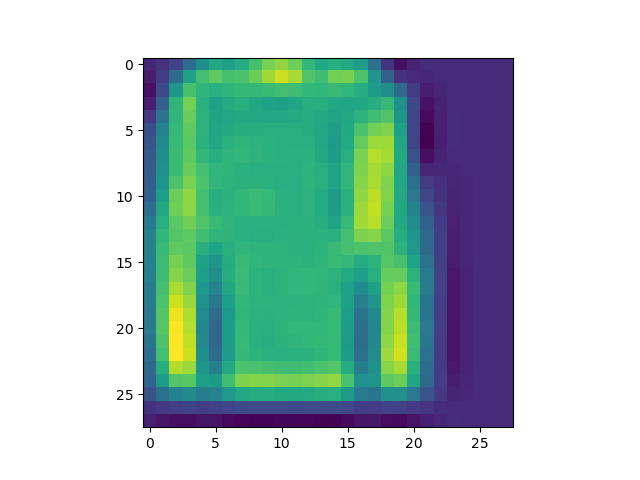

<IPython.core.display.Javascript object>


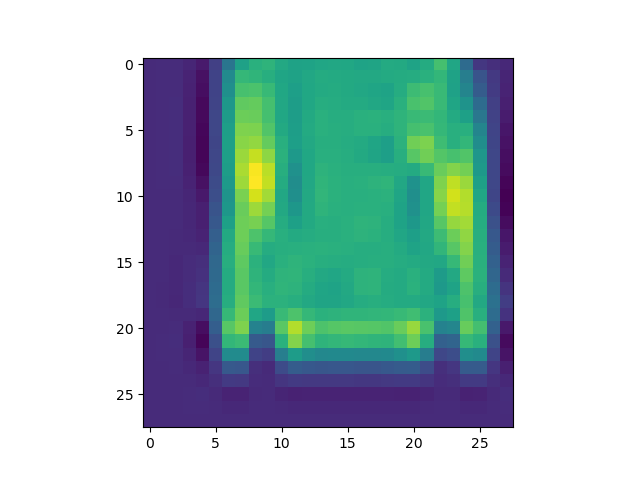

<IPython.core.display.Javascript object>


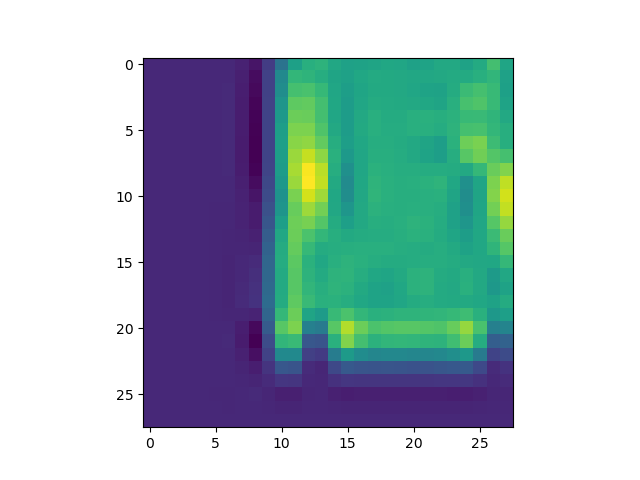

In [11]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [6]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, dvs = False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.

    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            ax[0,i].set_title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        
        steps  = []
        for j in range(5):
            steps.append(starting_point*1)
            starting_point += np.random.randint(-5,5,2) 
        
        if mixed_state:
            q_sequence = np.array(steps).astype(int)
        else:
            if count == 0:
                q_sequence = np.array(steps).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            ax[1,i].set_title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        count += 1
        


    ts_train = ts_images[:55_000]
    train_labels = labels[:55_000]
    ts_val = ts_images[55_000:]
    val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, transform = None):

            self.data = data
            self.labels = labels

            self.transform = transform
        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            data = self.data[idx]
            label = self.labels[idx]

            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels


    if dvs:
        train_dataset = mnist_dataset(dvs_train, train_labels)
        test_dataset = mnist_dataset(dvs_val, val_labels)
    else:
        train_dataset = mnist_dataset(ts_train, train_labels)
        test_dataset = mnist_dataset(ts_val, val_labels)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = False)

    
    return train_dataloader, test_dataloader, test_dataset

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [8]:
class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        img = img[:,0,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [9]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [10]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        if torch.cuda.is_available():
            hn = hn.to('cuda')
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [11]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

### See the fluctuation differences when we run on the same trajectory and see set the reandom seed

<IPython.core.display.Javascript object>


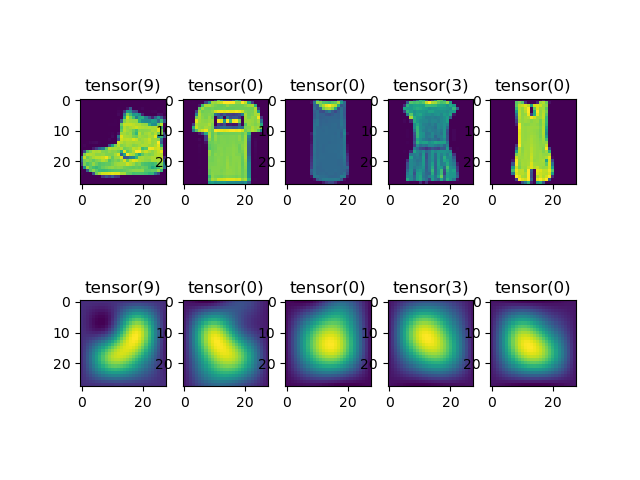

Net RNN_Net Epoch :  1 	 loss : 0.29431777494864303 accuracy : 80.75554
Net RNN_Net Epoch :  2 	 loss : 0.3806253845854045 accuracy : 81.03244
Net RNN_Net Epoch :  3 	 loss : 0.2580572317491844 accuracy : 81.42801
Net RNN_Net Epoch :  4 	 loss : 0.32899107421121276 accuracy : 81.07199


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.3161184219785413 accuracy : 80.08307
Net RNN_Net Epoch :  2 	 loss : 0.4117551339835302 accuracy : 81.15111
Net RNN_Net Epoch :  3 	 loss : 0.2452660005444649 accuracy : 81.86314
Net RNN_Net Epoch :  4 	 loss : 0.3281068084605032 accuracy : 80.93355


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.24244980826398452 accuracy : 80.18196
Net RNN_Net Epoch :  2 	 loss : 0.44119852419783373 accuracy : 80.518196
Net RNN_Net Epoch :  3 	 loss : 0.2838504317404885 accuracy : 81.60601
Net RNN_Net Epoch :  4 	 loss : 0.2534092652408014 accuracy : 81.586235


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.3441758300262434 accuracy : 79.707275
Net RNN_Net Epoch :  2 	 loss : 0.33939812263774194 accuracy : 80.59731
Net RNN_Net Epoch :  3 	 loss : 0.23742454540581753 accuracy : 82.27848
Net RNN_Net Epoch :  4 	 loss : 0.35905955640415654 accuracy : 81.7049


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.35769567806420394 accuracy : 80.61709
Net RNN_Net Epoch :  2 	 loss : 0.4852644378545965 accuracy : 80.913765
Net RNN_Net Epoch :  3 	 loss : 0.2592471743074426 accuracy : 81.78402
Net RNN_Net Epoch :  4 	 loss : 0.351813053318811 accuracy : 81.56645


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.3027126199023163 accuracy : 80.75554
Net RNN_Net Epoch :  2 	 loss : 0.3150602402987467 accuracy : 81.68513
Net RNN_Net Epoch :  3 	 loss : 0.2176503887973983 accuracy : 81.64557
Net RNN_Net Epoch :  4 	 loss : 0.2416584480028325 accuracy : 81.586235


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.39039557012459447 accuracy : 80.12263
Net RNN_Net Epoch :  2 	 loss : 0.33641529329887254 accuracy : 80.913765
Net RNN_Net Epoch :  3 	 loss : 0.2192985344393027 accuracy : 81.803795
Net RNN_Net Epoch :  4 	 loss : 0.3712840023324353 accuracy : 81.60601


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.356958949500903 accuracy : 80.35997
Net RNN_Net Epoch :  2 	 loss : 0.40600111664662303 accuracy : 81.269775
Net RNN_Net Epoch :  3 	 loss : 0.22467989849257108 accuracy : 81.942245
Net RNN_Net Epoch :  4 	 loss : 0.2744770547954025 accuracy : 81.30933


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.438711679916602 accuracy : 80.30064
Net RNN_Net Epoch :  2 	 loss : 0.315788525183402 accuracy : 81.408226
Net RNN_Net Epoch :  3 	 loss : 0.2784322766551545 accuracy : 81.82358
Net RNN_Net Epoch :  4 	 loss : 0.3075082237556818 accuracy : 81.88291


<IPython.core.display.Javascript object>

Net RNN_Net Epoch :  1 	 loss : 0.33432111284689975 accuracy : 80.43908
Net RNN_Net Epoch :  2 	 loss : 0.39308677806912923 accuracy : 81.25
Net RNN_Net Epoch :  3 	 loss : 0.24909568547913993 accuracy : 82.17959
Net RNN_Net Epoch :  4 	 loss : 0.2877121369257053 accuracy : 81.66535


<IPython.core.display.Javascript object>

In [18]:
#Here we compare 10 different drewn treajectories
#Get the confusion to see what particular images each trajectory worked best

train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
indices = []
for times in range(10):
    torch.manual_seed(0)
    lr = 3e-3
    epochs = 4
    net = RNN_Net().double()
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()

    train_loss = []
    test_loss = []
    test_accur = []
    test_predictions = None
    for epoch in range(epochs):
        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                if batch_idx == 0:
                    test_predictions = test_pred.squeeze(1)
                else:
                    test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    #plot confusion matricx and extract the indices where the mistakes where made 
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    targets = test_dataset.labels.tolist()
    confusion = confusion_matrix(targets, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    plt.savefig('no_restart_{}.png'.format(times))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")
    mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
    indices.append(mistaken)




In [20]:

#Build a matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices1 = indices
particular_confusion1 = np.ones([len(indices1), len(indices1)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
        particular_confusion1[i,j] = len([r for r in indices1[i] if r in indices1[j]])
print(particular_confusion1)

    

[[950. 765. 755. 755. 762. 750. 745. 760. 755. 747.]
 [765. 957. 753. 747. 751. 733. 739. 747. 746. 729.]
 [755. 753. 924. 746. 752. 746. 732. 753. 755. 752.]
 [755. 747. 746. 918. 744. 742. 745. 757. 742. 740.]
 [762. 751. 752. 744. 925. 738. 728. 745. 746. 743.]
 [750. 733. 746. 742. 738. 917. 722. 747. 735. 735.]
 [745. 739. 732. 745. 728. 722. 923. 740. 732. 729.]
 [760. 747. 753. 757. 745. 747. 740. 938. 767. 758.]
 [755. 746. 755. 742. 746. 735. 732. 767. 909. 755.]
 [747. 729. 752. 740. 743. 735. 729. 758. 755. 920.]]


In [24]:


#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices1)):
    particular_confusion1[i,:] /= particular_confusion1[i,i]
#get only the lower triangle
mean_confusion1 = np.tril(particular_confusion1, -1)
#Reshape to be a list

mean_confusion1 = mean_confusion1.reshape(particular_confusion1.shape[0] * particular_confusion1.shape[1])
mean_confusion1 = mean_confusion1.tolist()
#Delate all 0's from list
mean_confusion1 = [k for k in mean_confusion1 if k!=0]
#Now get the mean
std_confusion1 = np.round(np.std(mean_confusion1), decimals = 3)
mean_confusion1 = np.mean(mean_confusion1)

print(mean_confusion1, std_confusion1)


0.8088632594467219 0.012


In [32]:
#Find the best trajectory and best seed for each class and also the variance in the common mistakes - in general,
#between the two best and between the two worst.

#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 
very_particular_confusion1 = np.ones([10,len(indices1), len(indices1)])
run = 1
for class_ in range(10):
    for i in range(len(indices1)):
        for j in range(len(indices1)):         
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices1[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices1[j]]
                very_particular_confusion1[class_, i, j] = len(similar)
    #Find the BEST trajectory for this class ##############################################################
    diagonal = np.diagonal(very_particular_confusion1[class_,:,:])
    #get the two best run (min number of mistakes)
    min_mistakes = np.partition(diagonal, 1)[:2]
    indx1 = np.argwhere(diagonal == min_mistakes[0])
    indx2 = np.argwhere(diagonal == min_mistakes[1])
    #Get the shared mistakes between them
    shared = very_particular_confusion1[class_,indx1, indx2]
    print('On run {} - for class {} the two BEST trajectories misslabeled {} imgs \n {} were shared'.format(
                                                    run, class_, min_mistakes, shared))
    #Find the WORST trajectory for this class ############################################################
    #get the two best run (min number of mistakes)
    max_mistakes = np.partition(diagonal, 1)[-2:]
    indx1 = np.argwhere(diagonal == max_mistakes[0])
    indx2 = np.argwhere(diagonal == max_mistakes[1])
    #Get the shared mistakes between them
    shared = very_particular_confusion1[class_,indx1, indx2]
    print('On run {} - for class {} the two WORST trajectories misslabeled {} imgs \n {} were shared'.format(
                                                    run, class_, max_mistakes, shared))

very_particular_confusion1               

On run 1 - for class 0 the two BEST trajectories misslabeled [105. 112.] imgs 
 [[90.]] were shared
On run 1 - for class 0 the two WORST trajectories misslabeled [120. 125.] imgs 
 [[ 96.]
 [100.]] were shared
On run 1 - for class 1 the two BEST trajectories misslabeled [14. 16.] imgs 
 [[12.]] were shared
On run 1 - for class 1 the two WORST trajectories misslabeled [17. 27.] imgs 
 [[16.]] were shared
On run 1 - for class 2 the two BEST trajectories misslabeled [125. 126.] imgs 
 [[105.]] were shared
On run 1 - for class 2 the two WORST trajectories misslabeled [133. 135.] imgs 
 [[114.]] were shared
On run 1 - for class 3 the two BEST trajectories misslabeled [58. 60.] imgs 
 [[42.]] were shared
On run 1 - for class 3 the two WORST trajectories misslabeled [63. 78.] imgs 
 [[49.]] were shared
On run 1 - for class 4 the two BEST trajectories misslabeled [171. 174.] imgs 
 [[134.]] were shared
On run 1 - for class 4 the two WORST trajectories misslabeled [205. 188.] imgs 
 [[153.]
 [1

array([[[121., 103.,  96., 101., 101., 103., 107.,  98., 103., 101.],
        [103., 122.,  92., 100.,  97.,  94., 104.,  98.,  97.,  97.],
        [ 96.,  92., 105.,  94.,  91.,  90.,  96.,  90.,  92.,  93.],
        [101., 100.,  94., 131.,  99., 100., 112.,  98., 104., 104.],
        [101.,  97.,  91.,  99., 123., 102., 103.,  96.,  98., 100.],
        [103.,  94.,  90., 100., 102., 120., 102.,  95., 102.,  96.],
        [107., 104.,  96., 112., 103., 102., 134.,  99., 106., 108.],
        [ 98.,  98.,  90.,  98.,  96.,  95.,  99., 112., 100.,  95.],
        [103.,  97.,  92., 104.,  98., 102., 106., 100., 120., 100.],
        [101.,  97.,  93., 104., 100.,  96., 108.,  95., 100., 125.]],

       [[ 19.,  13.,  16.,  14.,  14.,  13.,  16.,  14.,  13.,  18.],
        [ 13.,  14.,  13.,  12.,  12.,  12.,  14.,  12.,  12.,  12.],
        [ 16.,  13.,  21.,  13.,  17.,  16.,  18.,  16.,  15.,  20.],
        [ 14.,  12.,  13.,  16.,  13.,  11.,  14.,  12.,  12.,  13.],
        [ 14.,  12

In [31]:
 np.partition(diagonal, 1)[-2:]

array([26., 32.])

In [34]:
#see the percentage of very_particular_confusion1 
for i in range(len(indices1)):
    for class_ in range(10):
        very_particular_confusion1[class_, i, :] /= very_particular_confusion1[class_, i, i] 
        
np.round(very_particular_confusion1, decimals = 2)

array([[[1.  , 0.85, 0.79, 0.83, 0.83, 0.85, 0.88, 0.81, 0.85, 0.83],
        [0.84, 1.  , 0.75, 0.82, 0.8 , 0.77, 0.85, 0.8 , 0.8 , 0.8 ],
        [0.91, 0.88, 1.  , 0.9 , 0.87, 0.86, 0.91, 0.86, 0.88, 0.89],
        [0.77, 0.76, 0.72, 1.  , 0.76, 0.76, 0.85, 0.75, 0.79, 0.79],
        [0.82, 0.79, 0.74, 0.8 , 1.  , 0.83, 0.84, 0.78, 0.8 , 0.81],
        [0.86, 0.78, 0.75, 0.83, 0.85, 1.  , 0.85, 0.79, 0.85, 0.8 ],
        [0.8 , 0.78, 0.72, 0.84, 0.77, 0.76, 1.  , 0.74, 0.79, 0.81],
        [0.88, 0.88, 0.8 , 0.88, 0.86, 0.85, 0.88, 1.  , 0.89, 0.85],
        [0.86, 0.81, 0.77, 0.87, 0.82, 0.85, 0.88, 0.83, 1.  , 0.83],
        [0.81, 0.78, 0.74, 0.83, 0.8 , 0.77, 0.86, 0.76, 0.8 , 1.  ]],

       [[1.  , 0.68, 0.84, 0.74, 0.74, 0.68, 0.84, 0.74, 0.68, 0.95],
        [0.93, 1.  , 0.93, 0.86, 0.86, 0.86, 1.  , 0.86, 0.86, 0.86],
        [0.76, 0.62, 1.  , 0.62, 0.81, 0.76, 0.86, 0.76, 0.71, 0.95],
        [0.88, 0.75, 0.81, 1.  , 0.81, 0.69, 0.88, 0.75, 0.75, 0.81],
        [0.74, 0.6

### See the changes from different trajectories - are they more sugnificant then the random ones? 

<IPython.core.display.Javascript object>


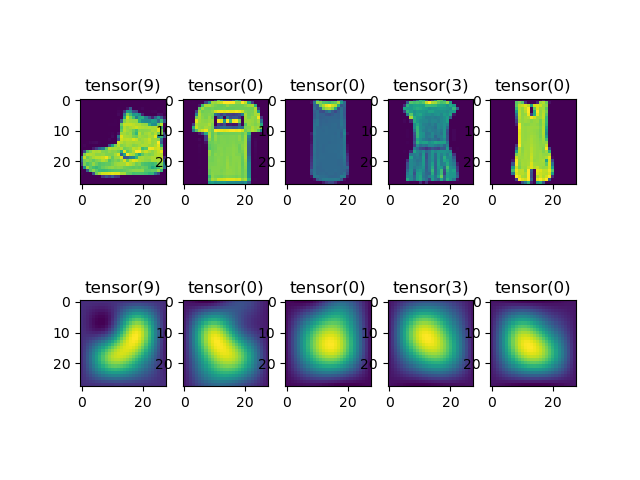

Net RNN_Net Epoch :  1 	 loss : 0.32905652442104244 accuracy : 79.4106
Net RNN_Net Epoch :  2 	 loss : 0.4174814184146449 accuracy : 81.30933
Net RNN_Net Epoch :  3 	 loss : 0.31819036353430746 accuracy : 82.21915
Net RNN_Net Epoch :  4 	 loss : 0.22450041454125272 accuracy : 82.91139


<IPython.core.display.Javascript object>


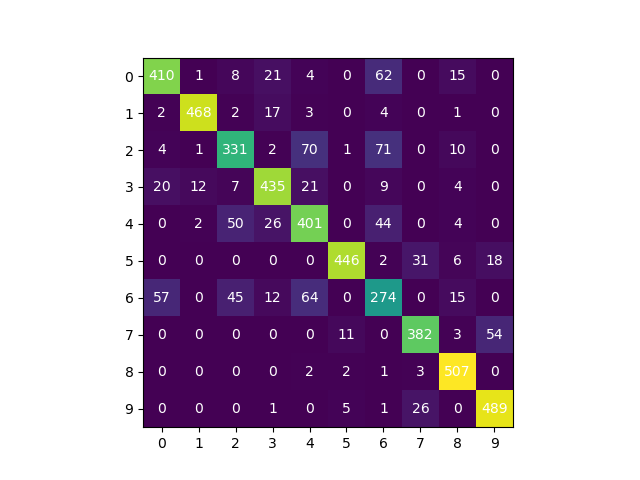

<IPython.core.display.Javascript object>


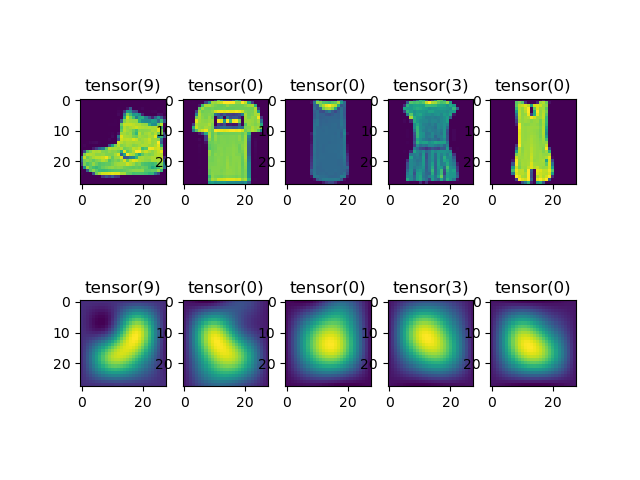

Net RNN_Net Epoch :  1 	 loss : 0.16673360696474857 accuracy : 78.817245
Net RNN_Net Epoch :  2 	 loss : 0.11968342527582582 accuracy : 80.87421
Net RNN_Net Epoch :  3 	 loss : 0.1335161974323751 accuracy : 81.724686
Net RNN_Net Epoch :  4 	 loss : 0.11538332954660256 accuracy : 82.37737


<IPython.core.display.Javascript object>


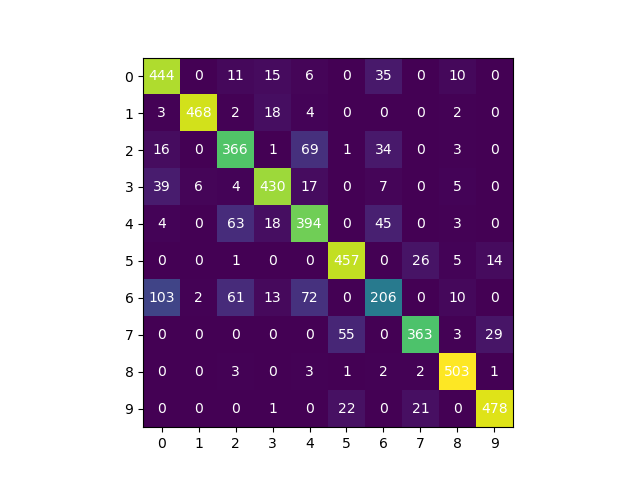

<IPython.core.display.Javascript object>


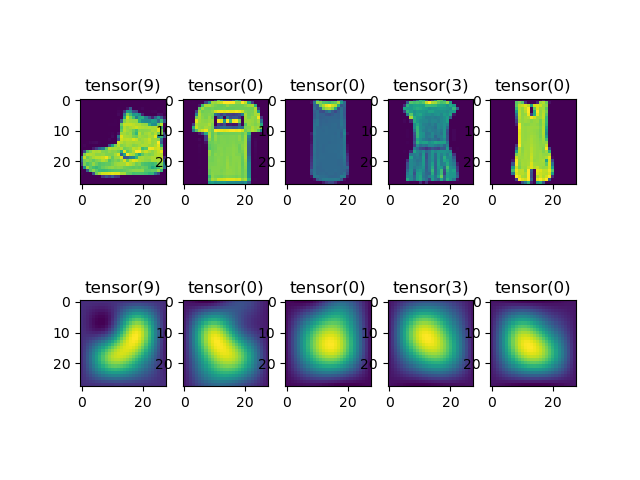

Net RNN_Net Epoch :  1 	 loss : 0.20509953841797118 accuracy : 82.06092
Net RNN_Net Epoch :  2 	 loss : 0.13172781474378384 accuracy : 82.792725
Net RNN_Net Epoch :  3 	 loss : 0.17692482110029825 accuracy : 82.89162
Net RNN_Net Epoch :  4 	 loss : 0.12709042166502504 accuracy : 83.84098


<IPython.core.display.Javascript object>


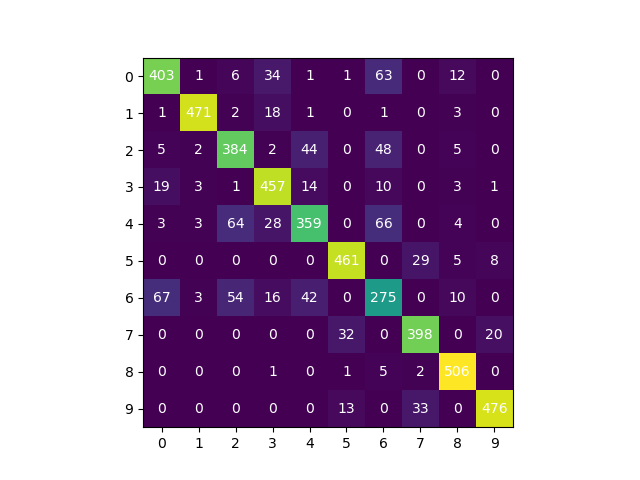

<IPython.core.display.Javascript object>


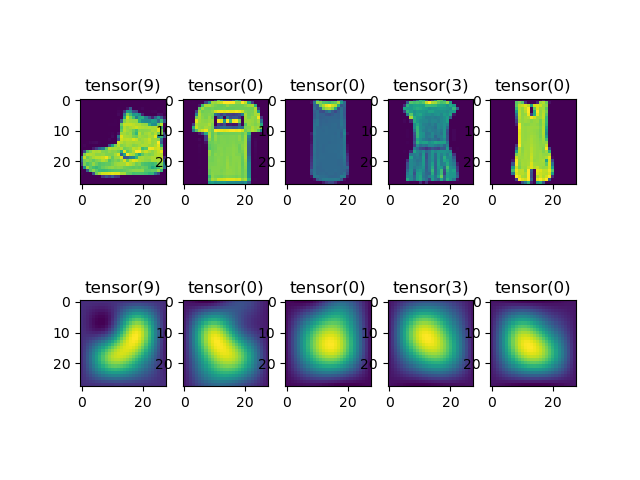

Net RNN_Net Epoch :  1 	 loss : 0.19920566287048952 accuracy : 81.942245
Net RNN_Net Epoch :  2 	 loss : 0.16645046882898548 accuracy : 82.93117
Net RNN_Net Epoch :  3 	 loss : 0.1392921320091914 accuracy : 83.62342
Net RNN_Net Epoch :  4 	 loss : 0.2623383093303484 accuracy : 84.19699


<IPython.core.display.Javascript object>


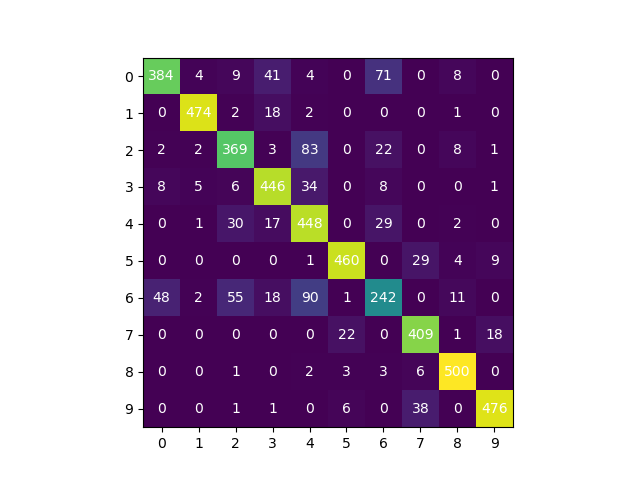

<IPython.core.display.Javascript object>


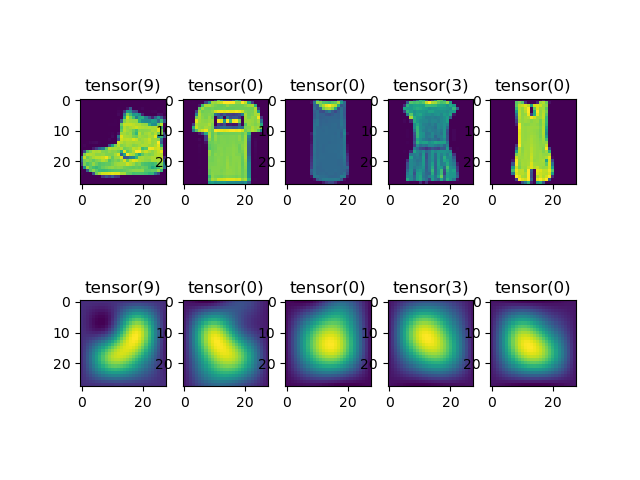

Net RNN_Net Epoch :  1 	 loss : 0.3240233551281208 accuracy : 79.90506
Net RNN_Net Epoch :  2 	 loss : 0.18691952341678694 accuracy : 83.76186
Net RNN_Net Epoch :  3 	 loss : 0.1591399277216369 accuracy : 83.16851
Net RNN_Net Epoch :  4 	 loss : 0.150676162806277 accuracy : 83.66297


<IPython.core.display.Javascript object>


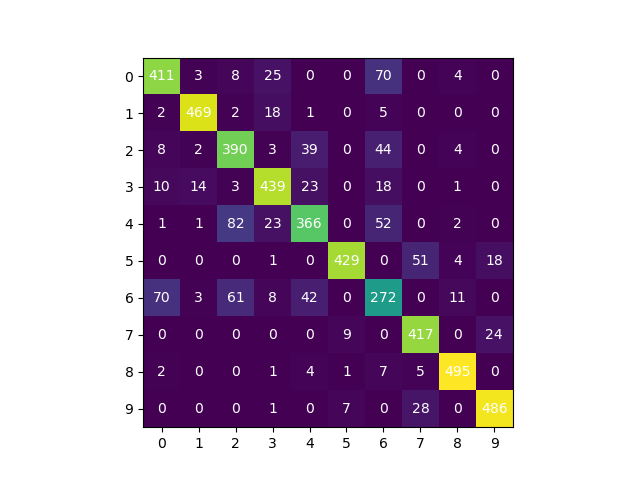

<IPython.core.display.Javascript object>


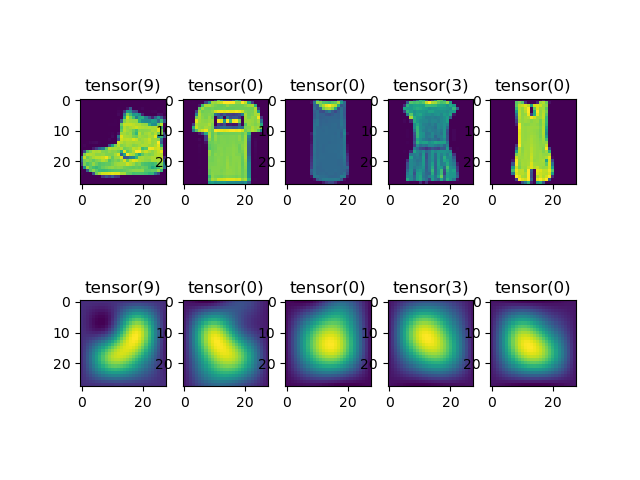

Net RNN_Net Epoch :  1 	 loss : 0.2489674077852856 accuracy : 81.25
Net RNN_Net Epoch :  2 	 loss : 0.3140234826715348 accuracy : 81.96203
Net RNN_Net Epoch :  3 	 loss : 0.16872953347178177 accuracy : 82.63449
Net RNN_Net Epoch :  4 	 loss : 0.26899632924134437 accuracy : 83.326744


<IPython.core.display.Javascript object>


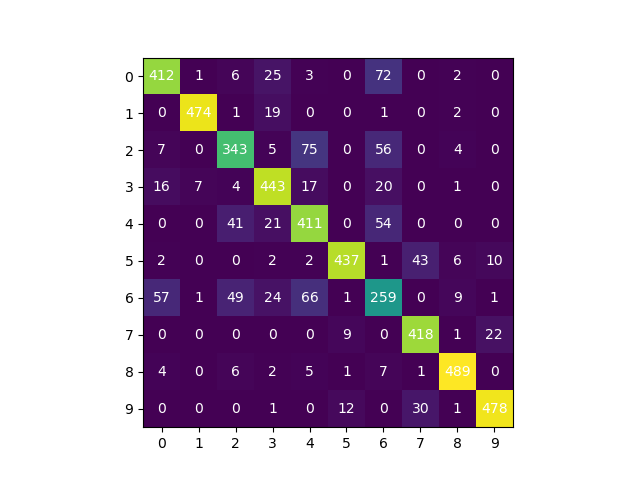

<IPython.core.display.Javascript object>


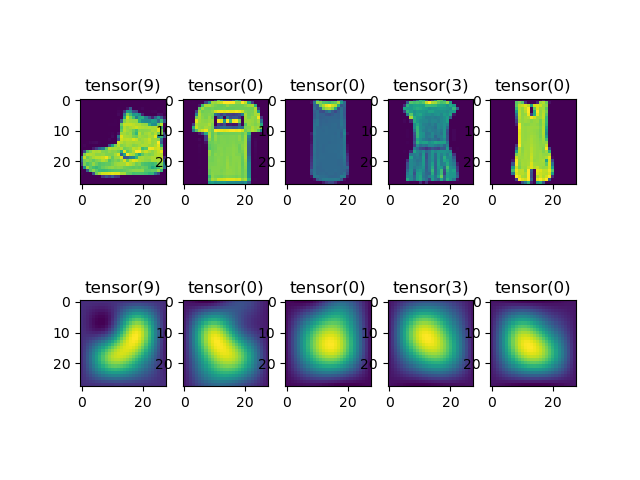

Net RNN_Net Epoch :  1 	 loss : 0.30825654589513246 accuracy : 79.72706
Net RNN_Net Epoch :  2 	 loss : 0.23853144419882652 accuracy : 81.74446
Net RNN_Net Epoch :  3 	 loss : 0.14812287781489766 accuracy : 82.73338
Net RNN_Net Epoch :  4 	 loss : 0.1762346827365155 accuracy : 81.803795


<IPython.core.display.Javascript object>


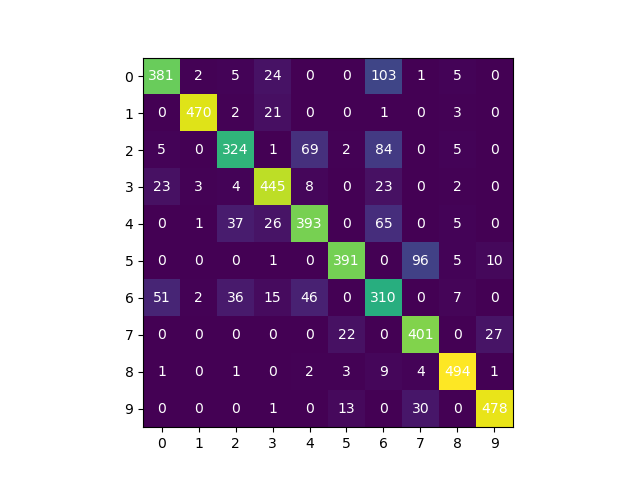

<IPython.core.display.Javascript object>


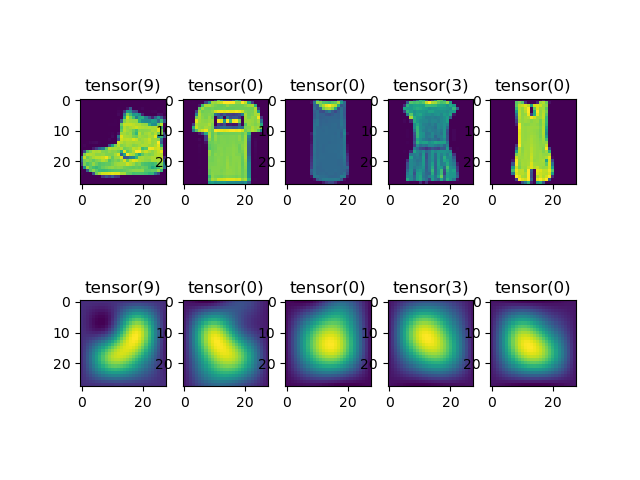

Net RNN_Net Epoch :  1 	 loss : 0.4792550123167836 accuracy : 76.42405
Net RNN_Net Epoch :  2 	 loss : 0.36429315190161554 accuracy : 78.599686
Net RNN_Net Epoch :  3 	 loss : 0.4222653329617366 accuracy : 80.00395
Net RNN_Net Epoch :  4 	 loss : 0.3040140840738712 accuracy : 80.34019


<IPython.core.display.Javascript object>


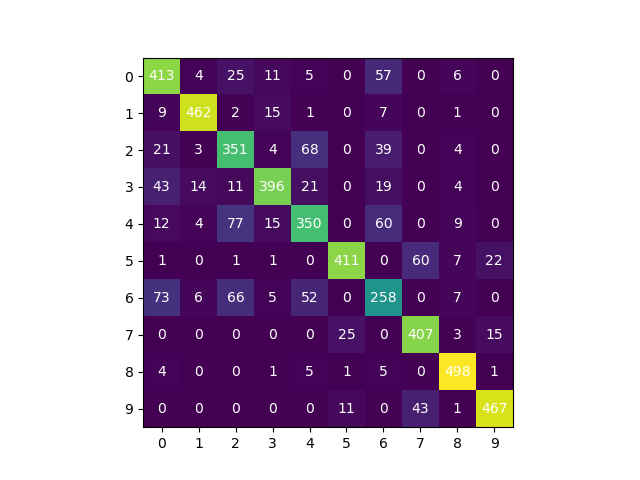

<IPython.core.display.Javascript object>


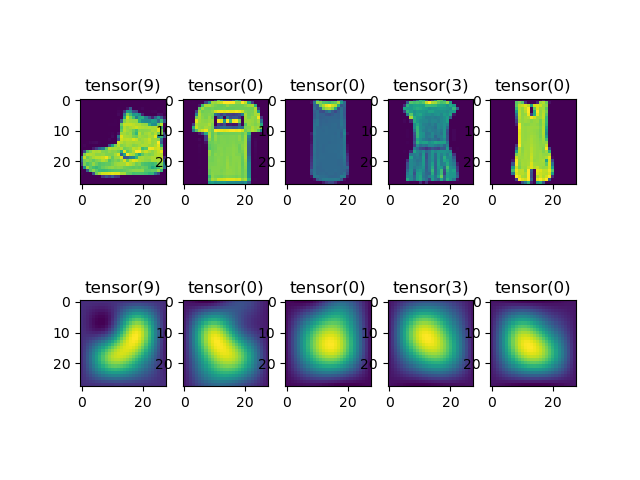

Net RNN_Net Epoch :  1 	 loss : 0.4218463474928622 accuracy : 78.48101
Net RNN_Net Epoch :  2 	 loss : 0.40211266936450385 accuracy : 80.59731
Net RNN_Net Epoch :  3 	 loss : 0.24495028265709018 accuracy : 80.775314
Net RNN_Net Epoch :  4 	 loss : 0.21544850918351852 accuracy : 81.84335


<IPython.core.display.Javascript object>


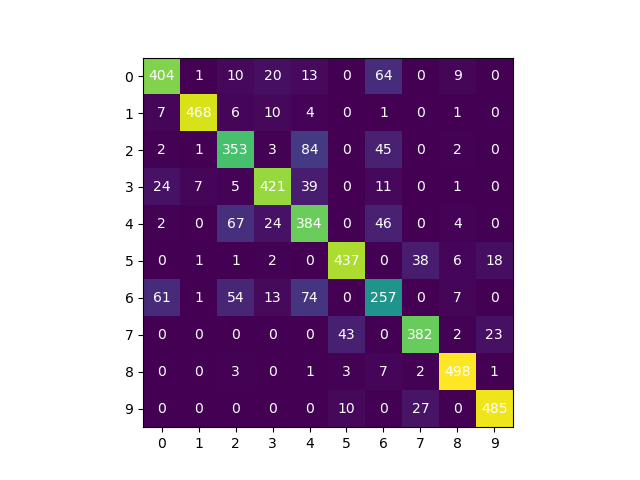

<IPython.core.display.Javascript object>


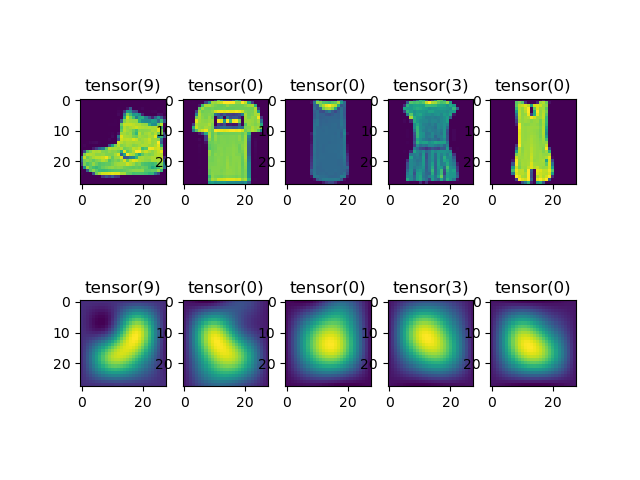

Net RNN_Net Epoch :  1 	 loss : 0.2327901107734788 accuracy : 80.35997
Net RNN_Net Epoch :  2 	 loss : 0.2032821896785636 accuracy : 81.764244
Net RNN_Net Epoch :  3 	 loss : 0.24006326013454962 accuracy : 81.052216
Net RNN_Net Epoch :  4 	 loss : 0.26650100106749697 accuracy : 83.03006


<IPython.core.display.Javascript object>


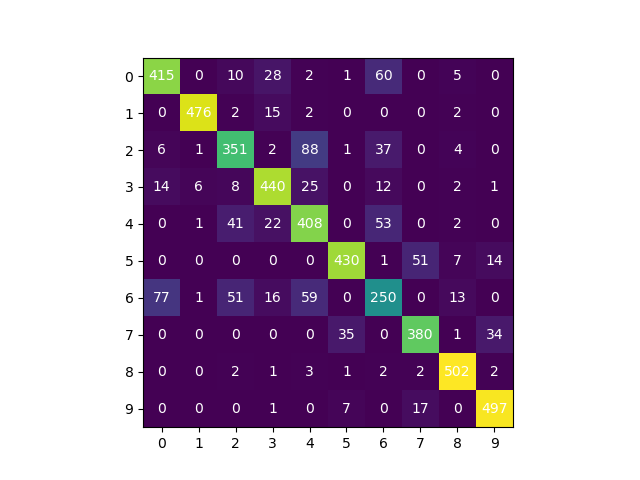

In [14]:
#Here we drew 10 different random networks
all_indices = []
#Get the confusion to see what particular images each trajectory worked best
torch.manual_seed(0)
indices = []
for times in range(10):
    #Load the training data
    train_dataloader, test_dataloader, test_dataset = create_dataset(images, labels,res = 6,mixed_state = False)
    lr = 3e-3
    epochs = 4
    net = RNN_Net().double()
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()

    train_loss = []
    test_loss = []
    test_accur = []
    test_predictions = None
    for epoch in range(epochs):
        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))
                if batch_idx == 0:
                    test_predictions = test_pred.squeeze(1)
                else:
                    test_predictions = torch.cat((test_predictions, test_pred.squeeze(1)), dim = 0)

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    #plot confusion matricx and extract the indices where the mistakes where made 
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    targets = test_dataset.labels.tolist()
    confusion = confusion_matrix(targets, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    plt.savefig('with_restart_{}.png'.format(times))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")
    mistaken = np.where(np.array(test_predictions) != np.array(targets))[0].tolist()
    indices.append(mistaken)
all_indices.append(indices)



In [15]:
#Build a matrix to hold the number of shared indices where the network was wrong (0d), number of overall 
#mistakes for trajectory i is on the diagonal
indices1 = indices
particular_confusion1 = np.ones([len(indices1), len(indices1)])
for i in range(len(indices1)):
    for j in range(len(indices1)):
        particular_confusion1[i,j] = len([r for r in indices1[i] if r in indices1[j]])
print(particular_confusion1)

    

[[857. 517. 512. 500. 509. 514. 527. 536. 550. 518.]
 [517. 891. 512. 511. 490. 525. 529. 561. 598. 569.]
 [512. 512. 810. 484. 488. 475. 536. 490. 548. 530.]
 [500. 511. 484. 792. 481. 490. 522. 483. 526. 523.]
 [509. 490. 488. 481. 826. 472. 479. 545. 503. 523.]
 [514. 525. 475. 490. 472. 836. 499. 523. 514. 502.]
 [527. 529. 536. 522. 479. 499. 913. 534. 546. 567.]
 [536. 561. 490. 483. 545. 523. 534. 987. 554. 543.]
 [550. 598. 548. 526. 503. 514. 546. 554. 911. 543.]
 [518. 569. 530. 523. 523. 502. 567. 543. 543. 851.]]


In [16]:

#Get the overall statistics:
#First, divide by the number of mistakes to get the percentage
for i in range(len(indices1)):
    particular_confusion1[i,:] /= particular_confusion1[i,i]
#get only the lower triangle
mean_confusion1 = np.tril(particular_confusion1, -1)
#Reshape to be a list

mean_confusion1 = mean_confusion1.reshape(particular_confusion1.shape[0] * particular_confusion1.shape[1])
mean_confusion1 = mean_confusion1.tolist()
#Delate all 0's from list
mean_confusion1 = [k for k in mean_confusion1 if k!=0]
#Now get the mean
std_confusion1 = np.round(np.std(mean_confusion1), decimals = 3)
mean_confusion1 = np.mean(mean_confusion1)

print(mean_confusion1, std_confusion1)

0.5912852114246558 0.041


In [17]:
#Find the best trajectory and best seed for each class and also the variance in the common mistakes - in general,
#between the two best and between the two worst.

#Find the differences for each particular label - ex. for label 5 what missclassification did run 1 did 
#compared to run 2? i.e. can we find a trajectory that was particularly different for a distinct class? 
#or are all the classes exsibit simillar veriance? 
very_particular_confusion1 = np.ones([10,len(indices1), len(indices1)])
run = 1
for class_ in range(10):
    for i in range(len(indices1)):
        for j in range(len(indices1)):         
                class_indices = np.where(np.array(test_dataset.labels) == np.array(class_))[0]
                #get only the misslabeled indices for class_ from i
                i_indices = [k for k in indices1[i] if k in class_indices]
                #see how many are similar between i and j in class_
                similar = [l for l in i_indices if l in indices1[j]]
                very_particular_confusion1[class_, i, j] = len(similar)
    #Find the BEST trajectory for this class ##############################################################
    diagonal = np.diagonal(very_particular_confusion1[class_,:,:])
    #get the two best run (min number of mistakes)
    min_mistakes = np.partition(diagonal, 1)[:2]
    indx1 = np.argwhere(diagonal == min_mistakes[0])
    indx2 = np.argwhere(diagonal == min_mistakes[1])
    #Get the shared mistakes between them
    shared = very_particular_confusion1[class_,indx1, indx2]
    print('On run {} - for class {} the two BEST trajectories misslabeled {} imgs \n {} were shared'.format(
                                                    run, class_, min_mistakes, shared))
    #Find the WORST trajectory for this class ############################################################
    #get the two best run (min number of mistakes)
    max_mistakes = np.partition(diagonal, 1)[-2:]
    indx1 = np.argwhere(diagonal == max_mistakes[0])
    indx2 = np.argwhere(diagonal == max_mistakes[1])
    #Get the shared mistakes between them
    shared = very_particular_confusion1[class_,indx1, indx2]
    print('On run {} - for class {} the two WORST trajectories misslabeled {} imgs \n {} were shared'.format(
                                                    run, class_, max_mistakes, shared))

very_particular_confusion1               

On run 1 - for class 0 the two BEST trajectories misslabeled [ 77. 106.] imgs 
 [[50.]] were shared
On run 1 - for class 0 the two WORST trajectories misslabeled [117. 111.] imgs 
 [[76.]] were shared
On run 1 - for class 1 the two BEST trajectories misslabeled [21. 23.] imgs 
 [[14.]
 [13.]] were shared
On run 1 - for class 1 the two WORST trajectories misslabeled [29. 29.] imgs 
 [[29.]
 [29.]
 [29.]] were shared
On run 1 - for class 2 the two BEST trajectories misslabeled [100. 106.] imgs 
 [[66.]] were shared
On run 1 - for class 2 the two WORST trajectories misslabeled [137. 139.] imgs 
 [[88.]
 [93.]] were shared
On run 1 - for class 3 the two BEST trajectories misslabeled [51. 62.] imgs 
 [[27.]] were shared
On run 1 - for class 3 the two WORST trajectories misslabeled [87. 68.] imgs 
 [[47.]] were shared
On run 1 - for class 4 the two BEST trajectories misslabeled [ 79. 116.] imgs 
 [[47.]] were shared
On run 1 - for class 4 the two WORST trajectories misslabeled [143. 119.] im

array([[[111.,  55.,  76.,  80.,  65.,  74.,  85.,  67.,  76.,  72.],
        [ 55.,  77.,  58.,  59.,  46.,  52.,  59.,  47.,  64.,  50.],
        [ 76.,  58., 118.,  88.,  71.,  66.,  83.,  69.,  76.,  77.],
        [ 80.,  59.,  88., 137.,  75.,  72.,  92.,  61.,  88.,  84.],
        [ 65.,  46.,  71.,  75., 110.,  60.,  71.,  62.,  63.,  69.],
        [ 74.,  52.,  66.,  72.,  60., 109.,  75.,  61.,  73.,  66.],
        [ 85.,  59.,  83.,  92.,  71.,  75., 140.,  66.,  79.,  78.],
        [ 67.,  47.,  69.,  61.,  62.,  61.,  66., 108.,  66.,  61.],
        [ 76.,  64.,  76.,  88.,  63.,  73.,  79.,  66., 117.,  69.],
        [ 72.,  50.,  77.,  84.,  69.,  66.,  78.,  61.,  69., 106.]],

       [[ 29.,  17.,  18.,  17.,  16.,  16.,  17.,  18.,  17.,  16.],
        [ 17.,  29.,  20.,  21.,  15.,  20.,  19.,  16.,  20.,  15.],
        [ 18.,  20.,  26.,  18.,  13.,  18.,  17.,  12.,  21.,  14.],
        [ 17.,  21.,  18.,  23.,  14.,  18.,  18.,  16.,  17.,  14.],
        [ 16.,  15

In [20]:
#see the percentage of very_particular_confusion1 
for i in range(len(indices1)):
    for class_ in range(10):
        very_particular_confusion1[class_, i, :] /= very_particular_confusion1[class_, i, i] 
        
very_particular_confusion1 = np.round(very_particular_confusion1, decimals = 2)
very_particular_confusion1                                

array([[[1.  , 0.5 , 0.68, 0.72, 0.59, 0.67, 0.77, 0.6 , 0.68, 0.65],
        [0.71, 1.  , 0.75, 0.77, 0.6 , 0.68, 0.77, 0.61, 0.83, 0.65],
        [0.64, 0.49, 1.  , 0.75, 0.6 , 0.56, 0.7 , 0.58, 0.64, 0.65],
        [0.58, 0.43, 0.64, 1.  , 0.55, 0.53, 0.67, 0.45, 0.64, 0.61],
        [0.59, 0.42, 0.65, 0.68, 1.  , 0.55, 0.65, 0.56, 0.57, 0.63],
        [0.68, 0.48, 0.61, 0.66, 0.55, 1.  , 0.69, 0.56, 0.67, 0.61],
        [0.61, 0.42, 0.59, 0.66, 0.51, 0.54, 1.  , 0.47, 0.56, 0.56],
        [0.62, 0.44, 0.64, 0.56, 0.57, 0.56, 0.61, 1.  , 0.61, 0.56],
        [0.65, 0.55, 0.65, 0.75, 0.54, 0.62, 0.68, 0.56, 1.  , 0.59],
        [0.68, 0.47, 0.73, 0.79, 0.65, 0.62, 0.74, 0.58, 0.65, 1.  ]],

       [[1.  , 0.59, 0.62, 0.59, 0.55, 0.55, 0.59, 0.62, 0.59, 0.55],
        [0.59, 1.  , 0.69, 0.72, 0.52, 0.69, 0.66, 0.55, 0.69, 0.52],
        [0.69, 0.77, 1.  , 0.69, 0.5 , 0.69, 0.65, 0.46, 0.81, 0.54],
        [0.74, 0.91, 0.78, 1.  , 0.61, 0.78, 0.78, 0.7 , 0.74, 0.61],
        [0.57, 0.5

In [ ]:
very_particular_confusion2 = np.round(very_particular_confusion2, decimals = 2)
very_particular_confusion2  

In [26]:
lower = np.tril(very_particular_confusion2, -1)
lower = lower.tolist()
lower = [l for l in lower if l !=0]
lower

[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.4146341463414634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.3877551020408163,
   0.3673469387755102,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.4, 0.4, 0.525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.3953488372093023,
   0.46511627906976744,
   0.37209302325581395,
   0.3023255813953488,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.7222222222222222,
   0.7777777777777778,
   0.6666666666666666,
   0.6666666666666666,
   0.6666666666666666,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.4375, 0.5, 0.625, 0.4375, 0.40625, 0.34375, 0.0, 0.0, 0.0, 0.0],
  [0.6190476190476191,
   0.5714285714285714,
   0.6666666666666666,
   0.5714285714285714,
   0.5714285714285714,
   0.5238095238095238,
   0.6190476190476191,
   0.0,
   0.0,
   0.0],
  [0.4594594594594595,
   0.43243243243243246,
   0.5945945945945946,
   0.40540540540540543,
   0.40540540540540543,
   0.3783783783783784,
   0.432432432

In [69]:
def plot_confusion(test_predictions,test_dataset):
    test_predictions = test_predictions.cpu().detach().numpy().tolist()
    #test_predictions.tolist()
    labels = test_dataset.labels.tolist()
    confusion = confusion_matrix(labels, test_predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(0,10))
    ax.set_yticklabels(np.arange(0,10))
    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w")